In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import statsmodels.api as sm

dados = pd.read_excel("C:/Users/Serrano/Downloads/Base de Dados - Lista 1 Macro.xls", sheet_name='Séries')
dados = dados[['Data', 'LN - Preço de Mercado', 'LN - Consumo Famílias', 'LN - Formação Bruta de Capital Fixo', 'LN - Horas Trabalhadas.1']]
dados = dados.rename(columns = {'LN - Preço de Mercado':'ln_preco_de_mercado',
                                'LN - Consumo Famílias': 'ln_consumo_familias',
                                'LN - Formação Bruta de Capital Fixo':'ln_fbcf',
                                'LN - Horas Trabalhadas.1': 'ln_horas_trabalhadas'})

def quarter_to_datetime(quarter):
    year, quarter_num = quarter.split(' T')
    month = int(quarter_num) * 3 - 2
    return pd.to_datetime(f'{year}-{month:02d}-01')

def trimestre_para_mes(trimestre):
    trimestres = {'1º': 1, '2º': 4, '3º': 7, '4º': 10}
    return trimestres.get(trimestre.split()[0])

def converter_para_datetime(data_texto):
    partes = data_texto.split()
    trimestre = trimestre_para_mes(partes[0])
    ano = int(partes[2])
    return datetime(ano, trimestre, 1)

dados['Data'] = dados['Data'].apply(quarter_to_datetime)
dados.set_index('Data', inplace=True)

for i in dados.columns:
    cycle, trend = sm.tsa.filters.hpfilter(dados[i], lamb=1600)
    dados[f'cycle_{i}'] = cycle
    dados[f'trend_{i}'] = trend

#dados.to_excel('lista1_macro1.xlsx', index=False)

In [32]:
gastos_gov = pd.read_excel("C:/Users/Serrano/Downloads/ipeadata[15-11-2023-01-09].xls")
gastos_gov.columns = ['data', 'gastos_governo']
gastos_gov['data'] = gastos_gov['data'].apply(quarter_to_datetime)
gastos_gov.set_index('data', inplace=True)
gastos_gov['ln_gastos_governo'] = np.log(gastos_gov['gastos_governo'])
cycle, trend = sm.tsa.filters.hpfilter(gastos_gov['ln_gastos_governo'], lamb=1600)
gastos_gov['ciclo_ln_gastos_governo'] = cycle
gastos_gov['trend_ln_gastos_governo'] = trend
#gastos_gov.to_excel('gasto_publico.xlsx', index=False)

desocupados = pd.read_excel("C:/Users/Serrano/Downloads/tabela6468.xlsx", skiprows = 1)
desocupados = desocupados.drop('Variável', axis = 1)
desocupados = desocupados.drop('Unnamed: 2', axis = 1)
desocupados = desocupados.rename(columns={'Trimestre':'data', 'Unnamed: 3':'tx_desocupacao'})
desocupados = desocupados.drop(46, axis = 0)
desocupados['data'] = desocupados['data'].apply(converter_para_datetime)
desocupados.index = desocupados['data']
desocupados = desocupados.drop('data', axis=1)
desocupados['ln_tx_desocupacao'] = np.log(desocupados['tx_desocupacao'])
cycle, trend = sm.tsa.filters.hpfilter(desocupados['ln_tx_desocupacao'], lamb=1600)
desocupados['ciclo_ln_tx_desocupacao'] = cycle
desocupados['trend_ln_tx_desocupacao'] = trend
#desocupados.to_excel('taxa_desocupacao.xlsx', index=False)

dados['ln_gastos_governo'] = gastos_gov['ln_gastos_governo']
dados['trend_ln_gastos_governo'] = gastos_gov['trend_ln_gastos_governo']
dados['ln_tx_desocupacao'] = desocupados['ln_tx_desocupacao']
dados['trend_ln_tx_desocupacao'] = desocupados['trend_ln_tx_desocupacao']

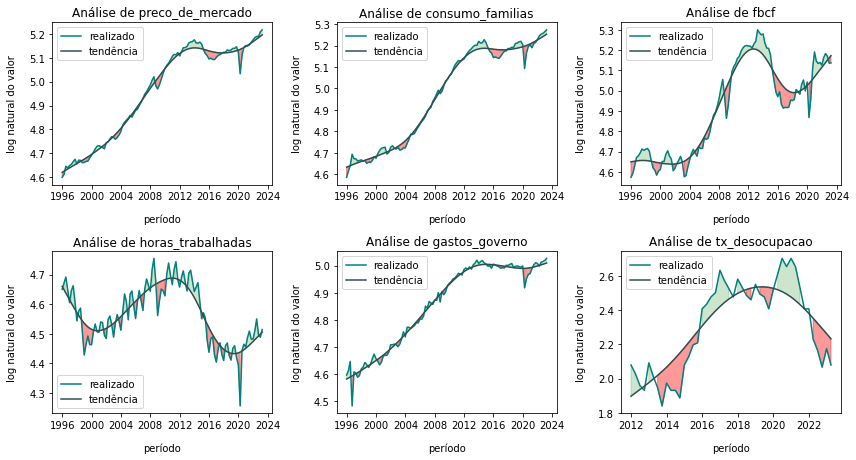

In [33]:
categorias = ['ln_preco_de_mercado', 'ln_consumo_familias', 'ln_fbcf', 'ln_horas_trabalhadas', 'ln_gastos_governo','ln_tx_desocupacao']

fig, axs = plt.subplots(2, 3, figsize=(12, 6.5))

for indice, categoria in enumerate(categorias):
    row = indice // 3  # Determina a linha do subplot
    col = indice % 3   # Determina a coluna do subplot

    axs[row, col].plot(dados[f'{categoria}'], label='realizado', color='teal')
    axs[row, col].plot(dados[f'trend_{categoria}'], label='tendência', color='darkslategrey')

    axs[row, col].set_xlabel('período', labelpad=12)
    axs[row, col].set_ylabel('log natural do valor', labelpad=12)

    axs[row, col].set_title(f'Análise de {categoria[3:]}')

    axs[row, col].fill_between(x=dados.index,
                               y1=dados[f'{categoria}'],
                               y2=dados[f'trend_{categoria}'],
                               alpha= 0.2,
                               where = dados[f'{categoria}'] > dados[f'trend_{categoria}'],
                               color='green')

    axs[row, col].fill_between(x=dados.index,
                               y1=dados[f'{categoria}'],
                               y2=dados[f'trend_{categoria}'],
                               alpha=0.4,
                               where=dados[f'{categoria}'] < dados[f'trend_{categoria}'],
                               color='red')

    axs[row, col].legend()

plt.tight_layout()
plt.show()